In [1]:
#**************************************************************************************************************#
# Implementation of a Variational Quantum Classifier (VQC) to predict the Survival of Passengers on Titanic 
#**************************************************************************************************************#

#**************************************************************************************************************#
# This implementation is based on the following references:
#
# 1. Matheus Cammarosano Hidalgo (2023). A very simple Variational Quantum Classifier (VQC).
#    Available on:
#    https://medium.com/@matheuscammarosanohidalgo/a-very-simple-variational-quantum-classifier-vqc-64e8ec26589d

# 2. Zickert, F. (2021). Chapter 2: Binary Classification. 
#    In F. Zickert, Hands-On Quantum Machine Learning With Python: Volume 1: Get Started, PyQML, 2021. 
#    Available on https://www.pyqml.com/
#
#**************************************************************************************************************#
# Code modified by Prof. Gustavo Patino for the Quantum Machine Learning Workshop at the IEEE-SSCI 2023
# adolfo.patino@udea.edu.co
# Mexico City - Mexico
# December 2023
#**************************************************************************************************************#


## 1. Imports

In [2]:
import pennylane as qml
from pennylane import numpy as np

## 2. Data Loading and Pre-Processing:

In [3]:
## Load the data from the csv‐files
import pandas as pd

# preparaing data
ds_train = pd.read_csv('data/train.csv')

In [4]:
print('The dataset train has {} rows and {} columns'.format(*ds_train.shape))

The dataset train has 891 rows and 12 columns


In [5]:
ds_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
ds_train['Pclass'] = ds_train['Pclass'].astype(str)
#ds_train.head()

In [8]:
# One-hot coding for each passenger's features.

ds_train = pd.concat([ds_train, pd.get_dummies(ds_train[['Pclass', 'Sex', 'Embarked']])], axis=1) # Convertion to on-hot decoding.
ds_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,1,0,0,1


In [9]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    object 
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Pclass_1     891 non-null    uint8  
 13  Pclass_2     891 non-null    uint8  
 14  Pclass_3     891 non-null    uint8  
 15  Sex_female   891 non-null    uint8  
 16  Sex_male     891 non-null    uint8  
 17  Embarked_C   891 non-null    uint8  
 18  Embarked_Q   891 non-null    uint8  
 19  Embarked

In [10]:
# I will fill missings with the median
ds_train['Age'] = ds_train['Age'].fillna(ds_train['Age'].mean())
#ds_train.info()

In [11]:
ds_train['is_child'] = ds_train['Age'].map(lambda x: 1 if x < 10 else 0)
#ds_train.info()

In [12]:
#ds_train.head()

In [13]:
################################################
## Separating train and test sets
################################################

In [14]:
cols_model = ['is_child', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female']

In [15]:
## Separating input from labels and training from testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ds_train[cols_model], ds_train['Survived'], test_size=0.2, random_state=42, stratify=ds_train['Survived'])

In [16]:
X_train = np.array(X_train.values, requires_grad=False)
print(X_train)

[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 ...
 [0 0 0 1 1]
 [0 1 0 0 0]
 [0 1 0 0 0]]


In [17]:
print('X_train has {} rows and {} columns'.format(*X_train.shape))

X_train has 712 rows and 5 columns


In [18]:
Y_train = np.array(y_train.values * 2 - np.ones(len(y_train)), requires_grad=False)
#print(Y_train)

In [19]:
print('We have {} training and {} testing rows'.format(X_train.shape[0], X_test.shape[0]))
print('There are {} input columns'.format(X_train.shape[1]))

We have 712 training and 179 testing rows
There are 5 input columns


In [20]:
#Save the data to the filesystem

with open('data/train.npy', 'wb') as f:
    np.save(f, X_train)
    np.save(f, y_train)

with open('data/test.npy', 'wb') as f:
    np.save(f, X_test)
    np.save(f, y_test)
    
#CAPTION Save the data to the filesystem

## 3. Quantum nodes

We create a quantum device with five "wires" (or qubits) based on the **qiskit aer** simulator.

In [21]:
#dev = qml.device("default.qubit", wires=num_qubits)

In [22]:
num_qubits = 5
num_layers = 2

In [23]:
import qiskit
dev = qml.device("qiskit.aer", wires=num_qubits)

For **Feature Map** and **Ansatz** circuits, you can check out the Pennylane templates, available at:
https://docs.pennylane.ai/en/stable/introduction/templates.html

In [24]:
# quantum circuit functions
def FeatureMap(x):
    qml.BasisEmbedding(x, wires=range(0, num_qubits))

In [25]:
def Ansatz(W):
    qml.StronglyEntanglingLayers(weights=W, wires=range(5))

In [26]:
@qml.qnode(dev, interface="autograd")

def circuit(weights, x):
    FeatureMap(x)
    qml.Barrier(wires=range(5))
    
    Ansatz(weights)
    qml.Barrier(wires=range(5))    
    
    return qml.expval(qml.PauliZ(0))

In [27]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [28]:
# setting init params
np.random.seed(0)
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [29]:
weights = weights_init
x = X_train[0]

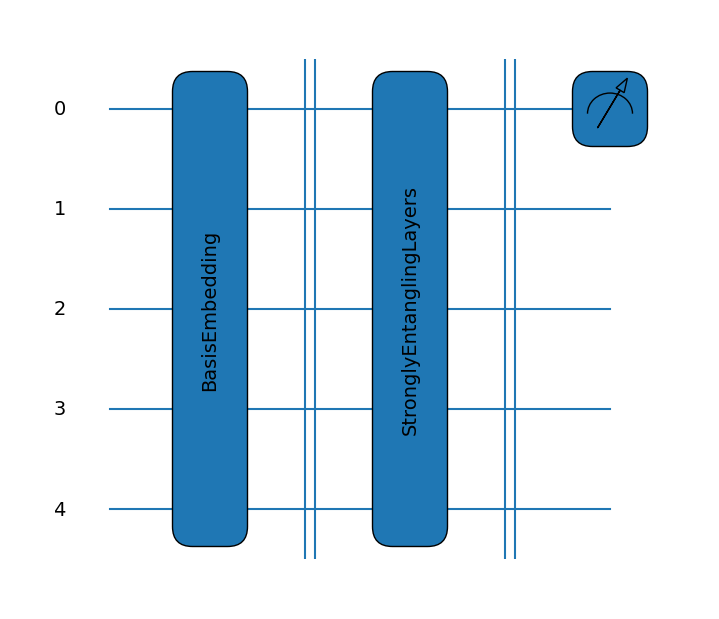

In [30]:
# Quantum circuit represented by Pennylane
qml.drawer.use_style("default")
fig, ax = qml.draw_mpl(circuit)(weights, x) # parameters given to the quantum circuit

In [31]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
#%config InlineBackend.figure_format = 'svg' # Makes the images look nice

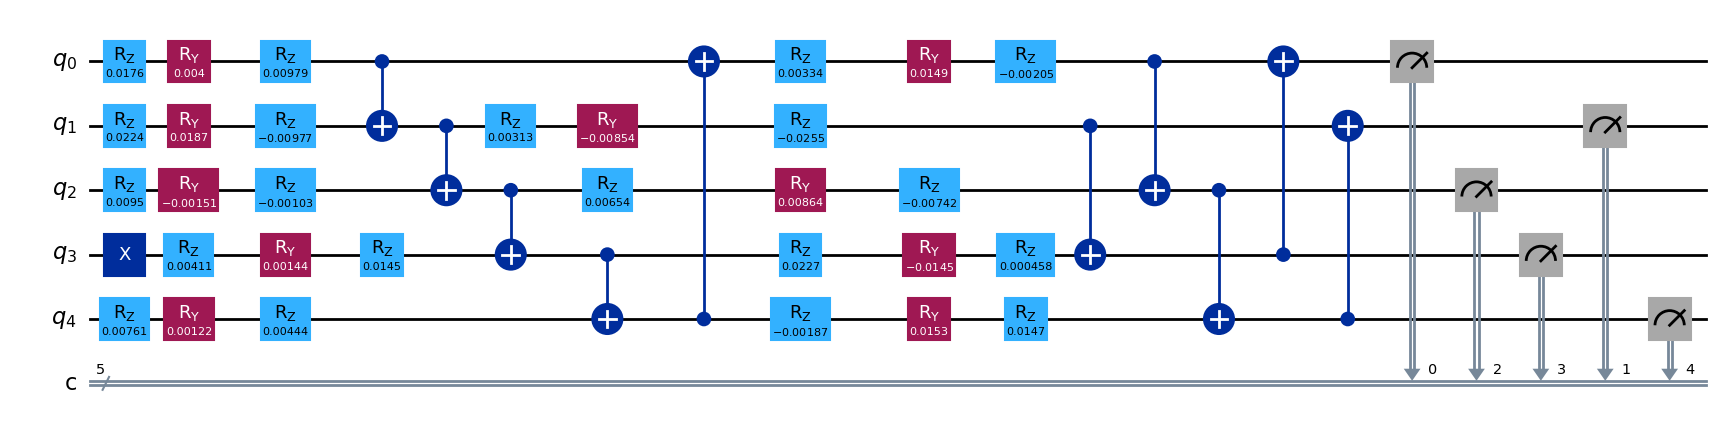

In [32]:
circuit(weights, x)
dev._circuit.draw(output="mpl", style="iqp")

Post-Processing:
-----------------------
## 4. Cost

In [33]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [34]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [35]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

Post-Processing:
-----------------------
## 5. Optimization

In [36]:
from pennylane.optimize import AdamOptimizer
import math

opt = AdamOptimizer(0.125)

In [37]:
num_it = 30
batch_size = math.floor(len(X_train)/num_it)

In [38]:
weights = weights_init
bias = bias_init
for it in range(num_it):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_train]
    acc = accuracy(Y_train, predictions)

    print("Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(it + 1, cost(weights, bias, X_train, Y_train), acc))

Iter:     1 | Cost: 2.3778234 | Accuracy: 0.3497191 
Iter:     2 | Cost: 2.1239894 | Accuracy: 0.3497191 
Iter:     3 | Cost: 1.8078947 | Accuracy: 0.3497191 
Iter:     4 | Cost: 1.5178775 | Accuracy: 0.3497191 
Iter:     5 | Cost: 1.2985071 | Accuracy: 0.5238764 
Iter:     6 | Cost: 1.1798913 | Accuracy: 0.6123596 
Iter:     7 | Cost: 1.1267727 | Accuracy: 0.6165730 
Iter:     8 | Cost: 1.0632463 | Accuracy: 0.6165730 
Iter:     9 | Cost: 1.0168591 | Accuracy: 0.6165730 
Iter:    10 | Cost: 0.9688155 | Accuracy: 0.6165730 
Iter:    11 | Cost: 0.9316176 | Accuracy: 0.6165730 
Iter:    12 | Cost: 0.8890653 | Accuracy: 0.6165730 
Iter:    13 | Cost: 0.8627842 | Accuracy: 0.6165730 
Iter:    14 | Cost: 0.8356165 | Accuracy: 0.6362360 
Iter:    15 | Cost: 0.8223407 | Accuracy: 0.6685393 
Iter:    16 | Cost: 0.8195143 | Accuracy: 0.6769663 
Iter:    17 | Cost: 0.8126492 | Accuracy: 0.6615169 
Iter:    18 | Cost: 0.7994060 | Accuracy: 0.6432584 
Iter:    19 | Cost: 0.7903518 | Accuracy: 0.64

In [39]:
X_test = np.array(X_test.values, requires_grad=False)
Y_test = np.array(y_test.values * 2 - np.ones(len(y_test)), requires_grad=False)

In [40]:
predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
accuracy_score(Y_test, predictions)
precision_score(Y_test, predictions)
recall_score(Y_test, predictions)
f1_score(Y_test, predictions, average='macro')

0.7584345479082322

## Platform and Tool Versions

In [42]:
import qiskit
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['Python-version']=platform.python_version()
        info['Pennylane-version']=info['Pennylane-version']=qml.version()
        info['Qiskit-version']=qiskit.__version__
        info['architecture']=platform.machine()
        info['hostname']=socket.gethostname()
        info['ip-address']=socket.gethostbyname(socket.gethostname())
        info['mac-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'platform': 'Windows',
 'platform-release': '10',
 'platform-version': '10.0.19045',
 'Python-version': '3.11.4',
 'Pennylane-version': '0.33.1',
 'Qiskit-version': '0.45.0',
 'architecture': 'AMD64',
 'hostname': 'DESKTOP-RRB2H12',
 'ip-address': '192.168.1.145',
 'mac-address': 'f0:1f:af:32:d1:ee',
 'processor': 'Intel64 Family 6 Model 58 Stepping 9, GenuineIntel',
 'ram': '16 GB'}